## ⚽ UEFA Insights – 2. Possession vs. Result Correlation

This notebook visualizes the myth whether more possessions result in more wins across tournament stages of UEFA Championship, seasons 2020, 2021, 2022.  

**Data source:** UEFA match data provided in DataCamp's Data Sources repository for DataLab projects hosted on Snowflake.

### SQL Query Setup
- Win/loss/draw breakdown when a team had possession advantage.
- Output is saved in a data frame 'possession_vs_result_corr' for later visualization.

In [1]:
WITH all_matches AS (
    SELECT '2020' AS SEASON, * FROM SOCCER.TBL_UEFA_2020
    UNION ALL
    SELECT '2021' AS SEASON, * FROM SOCCER.TBL_UEFA_2021
    UNION ALL
    SELECT '2022' AS SEASON, * FROM SOCCER.TBL_UEFA_2022
),
majority_possession AS (
SELECT
	SEASON,
	CASE
		WHEN POSSESSION_HOME > POSSESSION_AWAY THEN 'HOME'
		WHEN POSSESSION_AWAY > POSSESSION_HOME THEN 'AWAY'
	ELSE 'EQUAL'
	END AS POSSESSION_WINNER,

	CASE
		WHEN TEAM_HOME_SCORE > TEAM_AWAY_SCORE THEN 'HOME'
		WHEN TEAM_AWAY_SCORE > TEAM_HOME_SCORE THEN 'AWAY'
		ELSE 'DRAW'
		END AS MATCH_WINNER
FROM all_matches
),
possession_to_match_winner AS (
SELECT
	*,
	CASE
		WHEN POSSESSION_WINNER = MATCH_WINNER THEN 'Won with Possession'
		WHEN MATCH_WINNER = 'DRAW' THEN 'Draw despite Possession'
		ELSE 'Lost despite Possession'
		END AS POSSESSION_VS_RESULT
FROM majority_possession
)

SELECT 
	POSSESSION_VS_RESULT,
	COUNT(*) AS MATCH_COUNT,
	ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS PERCENTAGE
FROM possession_to_match_winner
GROUP BY POSSESSION_VS_RESULT
ORDER BY MATCH_COUNT DESC;

,POSSESSION_VS_RESULT,MATCH_COUNT,PERCENTAGE
0,Won with Possession,173,46.01
1,Lost despite Possession,127,33.78
2,Draw despite Possession,76,20.21


### SQL Query Setup
- Query setup for visualization of possession result types by season.
- Output is saved in a data frame 'possession_result_types' for later visualization.

In [2]:
WITH all_matches AS (
    SELECT '2020' AS SEASON, * FROM SOCCER.TBL_UEFA_2020
    UNION ALL
    SELECT '2021' AS SEASON, * FROM SOCCER.TBL_UEFA_2021
    UNION ALL
    SELECT '2022' AS SEASON, * FROM SOCCER.TBL_UEFA_2022
),
majority_possession AS (
SELECT
	SEASON,
	CASE
		WHEN POSSESSION_HOME > POSSESSION_AWAY THEN 'HOME'
		WHEN POSSESSION_AWAY > POSSESSION_HOME THEN 'AWAY'
	ELSE 'EQUAL'
	END AS POSSESSION_WINNER,

	CASE
		WHEN TEAM_HOME_SCORE > TEAM_AWAY_SCORE THEN 'HOME'
		WHEN TEAM_AWAY_SCORE > TEAM_HOME_SCORE THEN 'AWAY'
		ELSE 'DRAW'
		END AS MATCH_WINNER
FROM all_matches
),
possession_to_match_winner AS (
SELECT
	*,
	CASE
		WHEN POSSESSION_WINNER = MATCH_WINNER THEN 'POSSESSION_WIN_AND_MATCH_WIN'
		WHEN MATCH_WINNER = 'DRAW' THEN 'POSSESSION_WIN_DRAW'
		ELSE 'POSSESSION_WIN_BUT_LOST'
		END AS POSSESSION_VS_RESULT
FROM majority_possession
)

SELECT 
	SEASON,
	POSSESSION_VS_RESULT,
	COUNT(*) AS MATCH_COUNT,
	ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY SEASON), 2) AS PERCENTAGE
FROM possession_to_match_winner
GROUP BY SEASON, POSSESSION_VS_RESULT
ORDER BY SEASON;

,SEASON,POSSESSION_VS_RESULT,MATCH_COUNT,PERCENTAGE
0,2020,POSSESSION_WIN_BUT_LOST,41,32.54
1,2020,POSSESSION_WIN_DRAW,24,19.05
2,2020,POSSESSION_WIN_AND_MATCH_WIN,61,48.41
3,2021,POSSESSION_WIN_DRAW,26,20.80
4,2021,POSSESSION_WIN_BUT_LOST,52,41.60
5,2021,POSSESSION_WIN_AND_MATCH_WIN,47,37.60
6,2022,POSSESSION_WIN_BUT_LOST,34,27.20
7,2022,POSSESSION_WIN_AND_MATCH_WIN,65,52.00
8,2022,POSSESSION_WIN_DRAW,26,20.80


### Visualization 1 Setup:
**Data Source:** Data frame possession_vs_result_corr generated by a SQL query.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data frame 'possession_vs_result_corr' preview...

In [4]:
possession_vs_result_corr.sort_values('MATCH_COUNT', ascending = False).head()

,POSSESSION_VS_RESULT,MATCH_COUNT,PERCENTAGE
0,Won with Possession,173,46.01
1,Lost despite Possession,127,33.78
2,Draw despite Possession,76,20.21


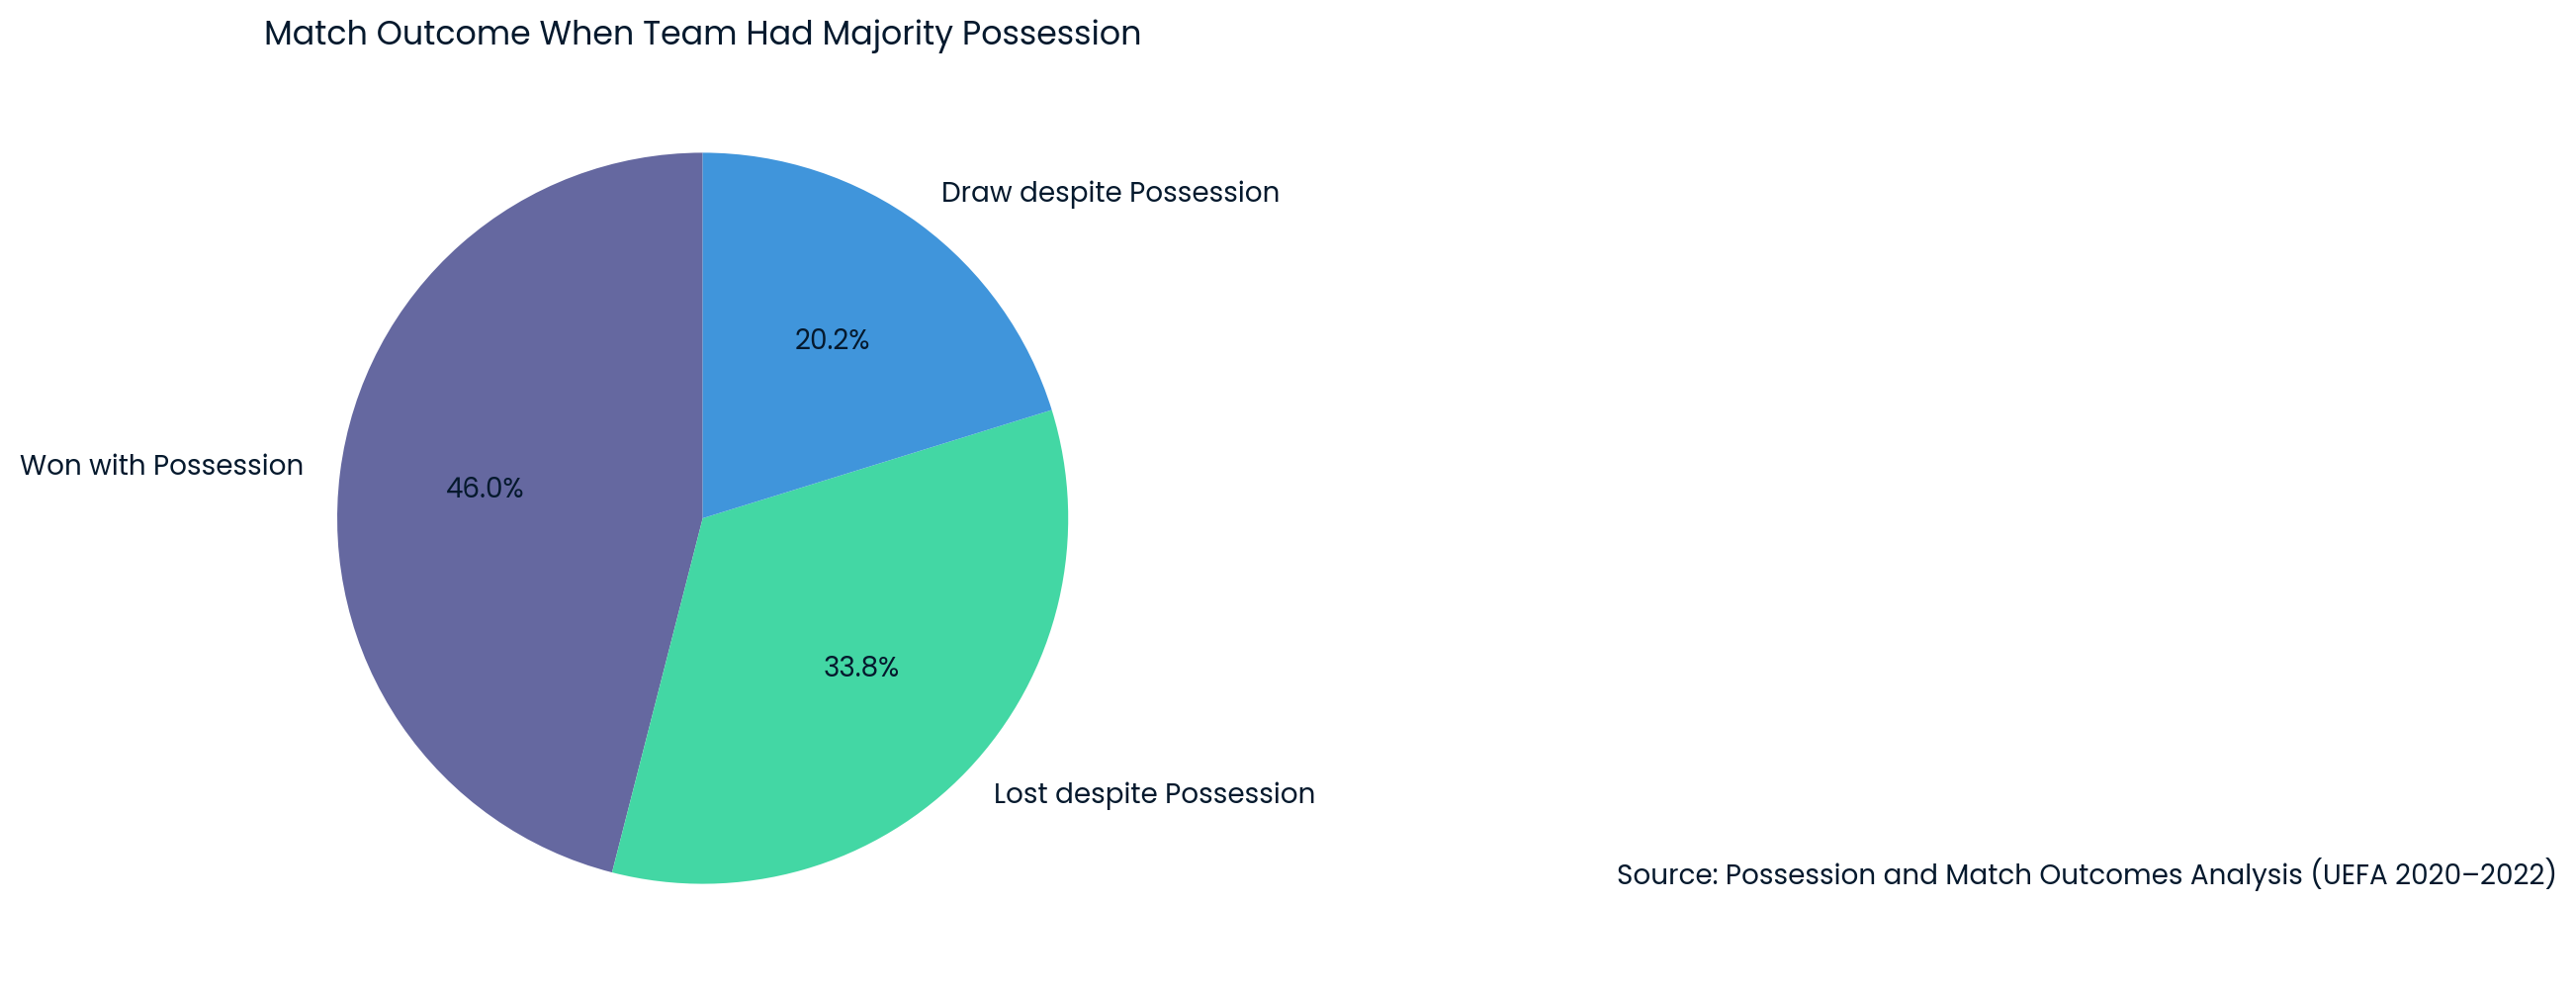

In [5]:
plt.figure(figsize = (6, 6))
plt.pie(possession_vs_result_corr['MATCH_COUNT'], labels = possession_vs_result_corr['POSSESSION_VS_RESULT'], autopct = '%1.1f%%', startangle = 90)
plt.title('Match Outcome When Team Had Majority Possession')
plt.text(2.5, -1.0, 'Source: Possession and Match Outcomes Analysis (UEFA 2020–2022)', fontsize = 10)
plt.show()

### Insight Reflection

- **Most Common Outcome**:  
  In overall, winning with majority possession indicates the possession-oriented styles of play across all seasons analyzed.

- **Unexpected Pattern**:  
  Losing with majority possession constituted a notable portion of matches accross all three seasons.

- **Real-World Meaning**:  
  While possession remains a key tactical advantage, match outcomes depend heavily on tactics and skillful players that win matches, not just a ball possession.


### Data frame 'possession_result_types' preview...

In [6]:
possession_result_types.sort_values('MATCH_COUNT', ascending = False).head()

,SEASON,POSSESSION_VS_RESULT,MATCH_COUNT,PERCENTAGE
7,2022,POSSESSION_WIN_AND_MATCH_WIN,65,52.00
2,2020,POSSESSION_WIN_AND_MATCH_WIN,61,48.41
4,2021,POSSESSION_WIN_BUT_LOST,52,41.60
5,2021,POSSESSION_WIN_AND_MATCH_WIN,47,37.60
0,2020,POSSESSION_WIN_BUT_LOST,41,32.54


### Visualization 2 Setup:
**Data Source:** Data frame 'possession_result_types' generated by a SQL query.
- **Chart 1** (left): Shows all outcomes together for each season.          
- **Chart 2** (right): Focuses attention on winning while having possession.

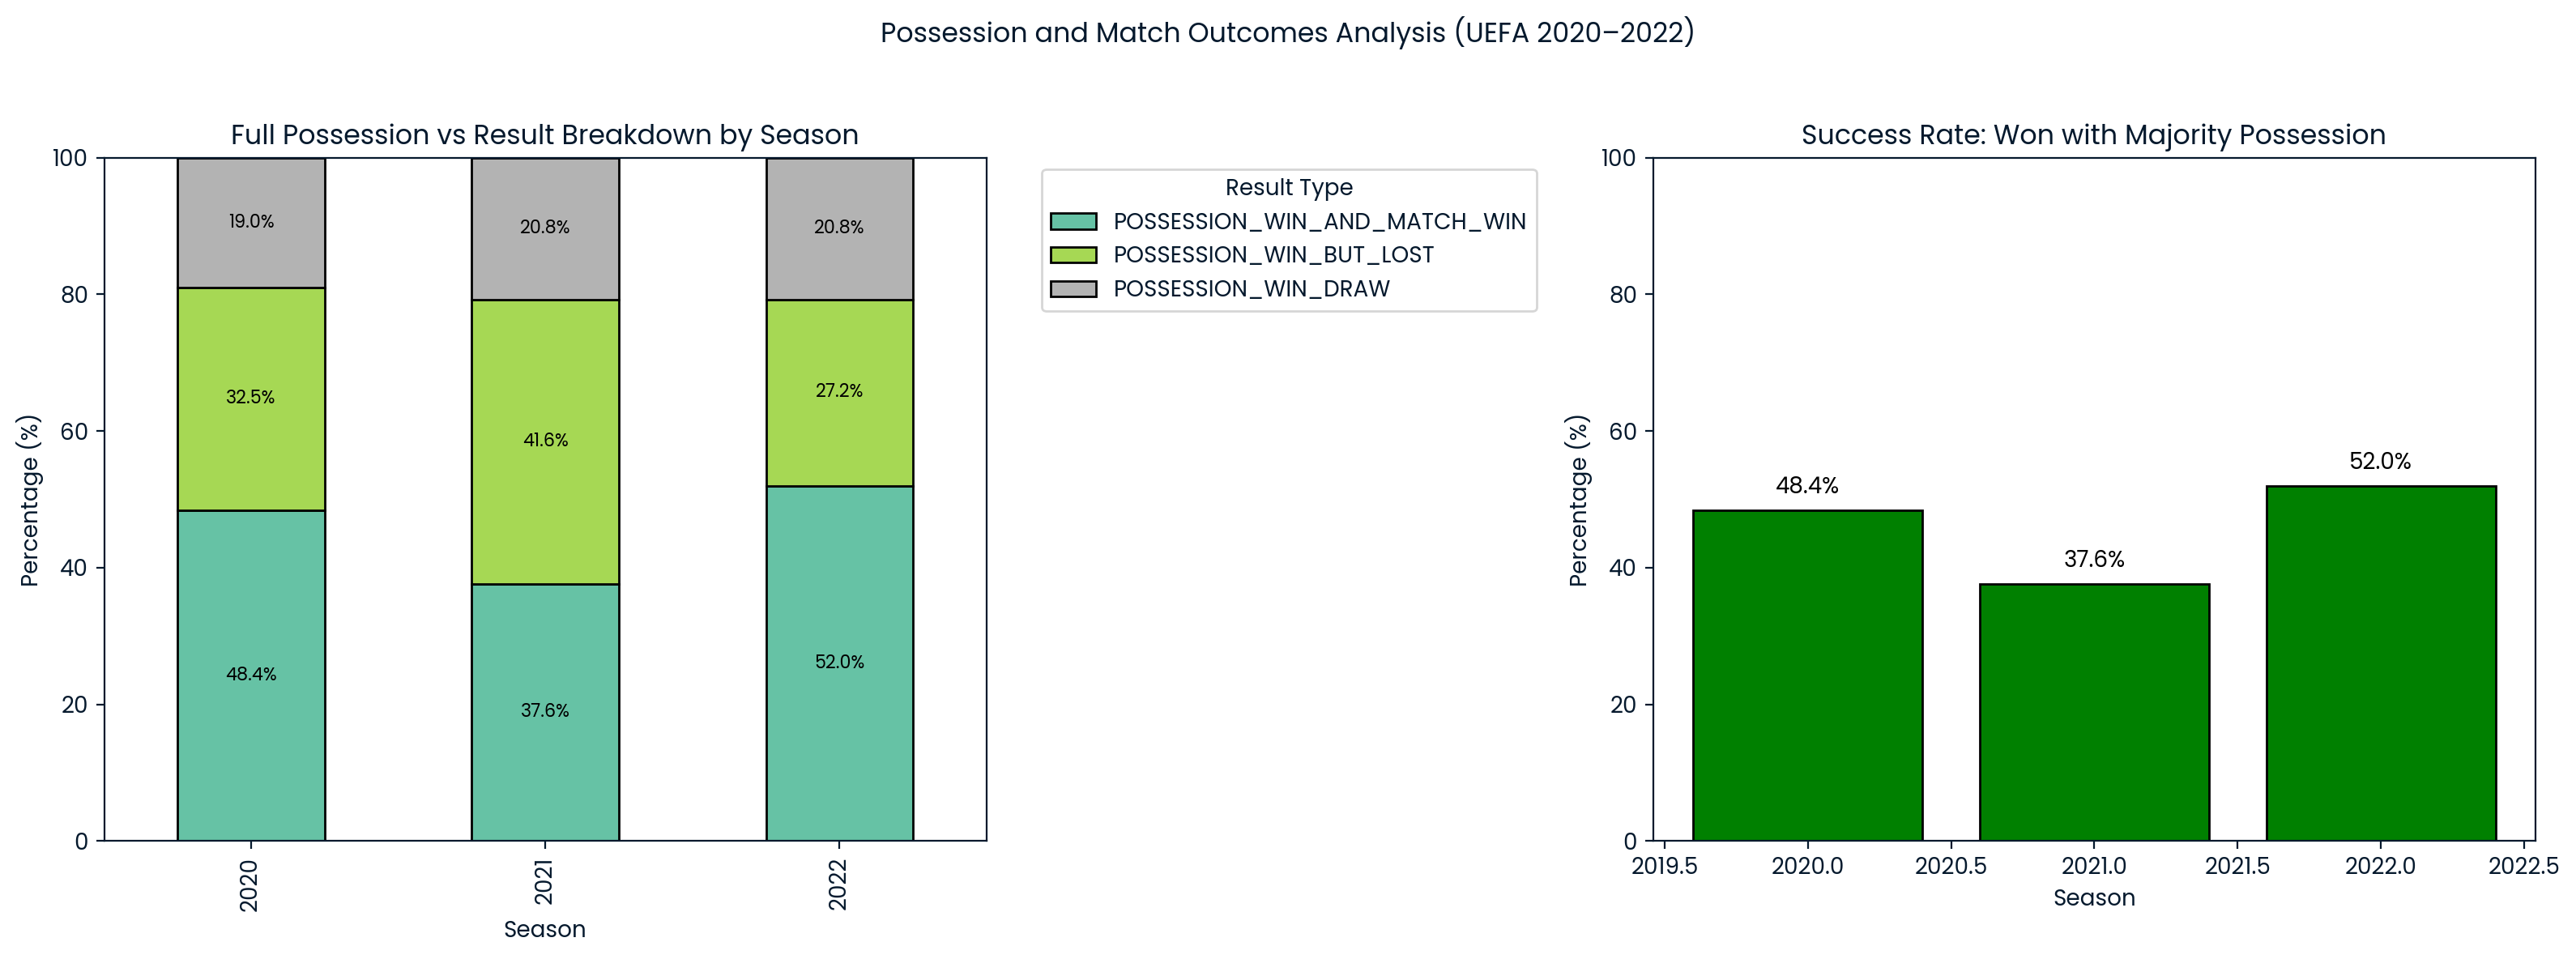

In [7]:
# Pivot full result types (percentages)
pivot_full = possession_result_types.pivot(index = "SEASON", columns = "POSSESSION_VS_RESULT", values = "PERCENTAGE")

# Filter only for "POSSESSION_WIN_AND_MATCH_WIN"
win_only = possession_result_types[possession_result_types["POSSESSION_VS_RESULT"] == "POSSESSION_WIN_AND_MATCH_WIN"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize = (16, 6))
fig.suptitle("Possession and Match Outcomes Analysis (UEFA 2020–2022)", fontsize = 12)

# --- Subplot 1: ---
pivot_full.plot(
    kind = "bar",
    stacked = True,
    ax = axes[0],
    colormap = "Set2",
    edgecolor = "black"
)

axes[0].set_title("Full Possession vs Result Breakdown by Season")
axes[0].set_ylabel("Percentage (%)")
axes[0].set_xlabel("Season")
axes[0].legend(title = "Result Type", bbox_to_anchor = (1.05, 1), loc = 'upper left')
axes[0].set_ylim(0, 100)

# Add percentage labels for stacked bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt = '%.1f%%', label_type = 'center', fontsize = 8, color = 'black')

# --- Subplot 2: ---
bars = axes[1].bar(
    win_only["SEASON"],
    win_only["PERCENTAGE"],
    color = "green",
    edgecolor = "black"
)

axes[1].set_title("Success Rate: Won with Majority Possession")
axes[1].set_ylabel("Percentage (%)")
axes[1].set_xlabel("Season")
axes[1].set_ylim(0, 100)

# Add percentage labels above bars
for bar in bars:
    height = bar.get_height()
    axes[1].annotate(f'{height:.1f}%',
                     xy = (bar.get_x() + bar.get_width() / 2, height),
                     xytext = (0, 5),  # Offset text a little above bar
                     textcoords = "offset points",
                     ha = 'center', va = 'bottom', fontsize = 10, color = 'black')

# Tidy layout
plt.tight_layout(rect = [0, 0, 1, 0.95])  # leave space for suptitle
plt.show()


### Insight Reflection

- **Most Common Outcome**:  
  Winning with majority possession is the most frequent result across all seasons analyzed.

- **Unexpected Pattern**:  
  Draws and even losses still occurred in a notable portion of matches, especially in the 2021 season.

- **Real-World Meaning**:  
  While possession remains a key tactical advantage, match outcomes depend heavily on teams’ ability to capitalize on their possession with effective attacking and defensive play.
